In [2]:
# Import Library yang dibutuhkan
!pip install joblib langdetect
!pip install emoji

from textwrap import wrap
import emoji
import joblib
import langdetect
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

# Set style untuk plot
plt.style.use("fivethirtyeight")

# Mengabaikan warning
warnings.filterwarnings("ignore")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 20.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993222 sha256=7076d9a1a589c27215c190170cfd4e26f80f2e99cb9342922a4a7d583d761a6d
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 12.1 MB/s eta 0:00:00


In [3]:
def get_category_dict(category_file):
    category = pd.read_json(category_file, orient="records")
    category = pd.DataFrame(category["items"].values.tolist())

    return {
        cat.id: cat.snippet.get("title")
        for cat in category.itertuples(index=False)
    }

In [4]:
def get_category_dict(category_file):
    category = pd.read_json(category_file, orient="records")
    category = pd.DataFrame(category["items"].values.tolist())

    return {
        cat.id: cat.snippet.get("title")
        for cat in category.itertuples(index=False)
    }

In [5]:
category_dict = get_category_dict("/content/drive/MyDrive/colleb/ujsp/category.json")

In [6]:
trending = pd.read_csv("/content/drive/MyDrive/colleb/ujsp/trending.csv", parse_dates=["publish_time", "trending_time"])

with pd.option_context("display.max_columns", None):
    display(trending.head())

,video_id,publish_time,channel_id,title,description,thumbnail_url,thumbnail_width,thumbnail_height,channel_name,tags,category_id,live_status,local_title,local_description,duration,dimension,definition,caption,license_status,allowed_region,blocked_region,view,like,dislike,favorite,comment,trending_time
0,NaN,2021-02-05 09:00:34+00:00,UCEf_Bc-KVd7onSeifS3py9g,aespa 에스파 'Forever (약속)' MV,"aespa's new single ""Forever"" is out!\nListen a...",NaN,NaN,NaN,SMTOWN,NaN,10,none,aespa 에스파 'Forever (약속)' MV,"aespa's new single ""Forever"" is out!\nListen a...",PT5M7S,2d,hd,True,True,NaN,NaN,7806846.0,857902.0,24078.0,0,94961.0,2021-02-07 05:46:51.832614+00:00
1,NaN,2021-02-04 15:54:08+00:00,UCYEa4_MC7OFjcWrO6SO-u8g,[FULL] Siapa di Balik Kudeta AHY? | Dua Sisi t...,"Jakarta, https://www.tvonenews.com - Ketua umu...",NaN,NaN,NaN,Indonesia Lawyers Club,"['tvone', 'tv one', 'tvonenews', 'indonesia la...",25,none,[FULL] Siapa di Balik Kudeta AHY? | Dua Sisi t...,"Jakarta, https://www.tvonenews.com - Ketua umu...",PT42M30S,2d,hd,False,True,NaN,NaN,885038.0,6765.0,1263.0,0,6365.0,2021-02-07 05:46:51.832649+00:00
2,NaN,2021-02-06 03:00:22+00:00,UCu12RxQjRQyh79YBYvEDkOg,CABRIOLET CHALLENGE: TANTANGAN MENGGODA (7/12),Road Party Season 2: Cabriolet Challenge\n\nEp...,NaN,NaN,NaN,Motomobi,"['MotoMobi', 'Mobil', 'motor', 'review', 'indo...",2,none,CABRIOLET CHALLENGE: TANTANGAN MENGGODA (7/12),Road Party Season 2: Cabriolet Challenge\n\nEp...,PT46M43S,2d,hd,False,True,NaN,NaN,889708.0,47895.0,532.0,0,8785.0,2021-02-07 05:46:51.832664+00:00
3,NaN,2021-02-05 20:26:08+00:00,UCCuzDCoI3EUOo_nhCj4noSw,With Windah Basudara & Hans,Join this channel to get access to perks:\nhtt...,NaN,NaN,NaN,yb,NaN,20,none,With Windah Basudara & Hans,Join this channel to get access to perks:\nhtt...,PT45M59S,2d,hd,False,True,NaN,NaN,1006854.0,91973.0,3967.0,0,12957.0,2021-02-07 05:46:51.832678+00:00
4,NaN,2021-02-03 23:14:54+00:00,UC14UlmYlSNiQCBe9Eookf_A,🤯 LATE COMEBACK DRAMA! | HIGHLIGHTS | Granada ...,"With just two minutes to play, Barça looked to...",NaN,NaN,NaN,FC Barcelona,"['FC Barcelona', 'برشلونة،', 'Fútbol', 'FUTBOL...",17,none,🤯 LATE COMEBACK DRAMA! | HIGHLIGHTS | Granada ...,"With just two minutes to play, Barça looked to...",PT5M12S,2d,hd,False,True,NaN,NaN,6275035.0,218131.0,4289.0,0,12799.0,2021-02-07 05:46:51.832730+00:00


In [7]:
start_date = trending.trending_time.min()
end_date = trending.trending_time.max()

print(f"{start_date = }")
print(f"{end_date = }")

start_date = '2021-02-07 05:46:51.832614+00:00'
end_date = '2023-09-01 09:16:49.916211+00:00'


In [8]:
# delete data dari bulan februari-juni
trending['trending_time'] = pd.to_datetime(trending['trending_time'], format='mixed', errors='coerce')
# The 'format='mixed'' argument allows pandas to infer the format for each element individually.
#The 'errors='coerce'' will set invalid values to NaT(Not a time).
filtered_trending = trending[trending.trending_time.dt.month >= 7 ]
start_date = filtered_trending.trending_time.min()
end_date = filtered_trending.trending_time.max()

print (f"{start_date =}")
print (f"{end_date =}")

start_date =Timestamp('2021-07-01 06:01:25.524449+0000', tz='UTC')
end_date =Timestamp('2023-09-01 09:16:49.916211+0000', tz='UTC')


In [9]:
num_videos = filtered_trending.shape[0]
print(f"{num_videos =}")

num_videos =81517


In [10]:
# Distribusi missing volue

filtered_trending.info()

<class 'pandas.core.frame.DataFrame'>
Index: 81517 entries, 21322 to 172346
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   video_id           49717 non-null  object             
 1   publish_time       81517 non-null  datetime64[ns, UTC]
 2   channel_id         81517 non-null  object             
 3   title              81517 non-null  object             
 4   description        78544 non-null  object             
 5   thumbnail_url      49717 non-null  object             
 6   thumbnail_width    49717 non-null  float64            
 7   thumbnail_height   49717 non-null  float64            
 8   channel_name       81517 non-null  object             
 9   tags               70149 non-null  object             
 10  category_id        81517 non-null  int64              
 11  live_status        81517 non-null  object             
 12  local_title        81517 non-null  object     

In [11]:
#Delete video dengan description kosong

filtered_trending.dropna(subset=["description"], inplace=True)

In [12]:
# Grouping berdasarkan tanggal
trending_by_date = filtered_trending.groupby(filtered_trending["trending_time"].dt.date)

# Menghitung jumlah video trending per hari
num_trending_per_day = trending_by_date["trending_time"].count()

# Menampilkan hasil
print("Number of videos in trending per day:", num_trending_per_day.unique())


Number of videos in trending per day: [195 196 197 198 194 193 192 191 190 188 187 185 189 186 184 183 132 182
 181 179 176 172 155 144 149 148 141 140 131 129 145 167 163 157 156 175
 169 199 200 381]


In [13]:
trending_duration = filtered_trending.groupby("title").agg(
    trending_duration=pd.NamedAgg(column="trending_time", aggfunc="count"),
    trending_start_date=pd.NamedAgg(column="trending_time", aggfunc="min"),
    trending_last_date=pd.NamedAgg(column="trending_time", aggfunc="max")
).sort_values("trending_duration", ascending=False).reset_index()

trending_duration.head(10)

,title,trending_duration,trending_start_date,trending_last_date
0,Toleransi antar tetangga di Korea🇰🇷.. 🤦🏻‍♂️,37,2022-07-02 06:01:31.621606+00:00,2022-08-07 06:01:00.607651+00:00
1,"JEJE PENGHUNI STASIUN DUKUH ATAS, PERNAH CABUT...",37,2022-07-02 06:01:31.621150+00:00,2022-08-07 06:01:00.607537+00:00
2,"NEGO 1 GEROBAK SHAWARMA VIRAL DI TIKTOK, SAMPE...",36,2022-07-08 06:01:39.900318+00:00,2022-08-12 06:01:33.892049+00:00
3,OPW ARES Sudah Tamat,35,2022-07-02 06:01:31.621296+00:00,2022-08-05 06:02:43.644196+00:00
4,"Tantangin VYN Pake Franco, 1 Kali Kena Hook Da...",35,2022-07-01 06:01:38.284040+00:00,2022-08-04 06:02:04.519603+00:00
5,SINGAPORE STREET FOOD #08,35,2022-07-02 06:01:31.621620+00:00,2022-08-06 06:02:02.694750+00:00
6,Kok di Indonesia ada penjual Rawon yg lebih pi...,34,2022-07-02 06:01:31.621592+00:00,2022-08-04 06:02:04.519738+00:00
7,SELAMAT LEBARAN GUYS!!!,33,2022-07-11 06:00:59.413948+00:00,2022-08-12 06:01:33.891919+00:00
8,"HANYA FARIDA NURHAN, MUKBANG MIE GACOAN LEVEL ...",32,2022-07-11 06:00:59.414152+00:00,2022-08-11 06:01:46.801212+00:00
9,BORONG ISI KULKAS SAMA BABY SHARK!!!,32,2022-07-02 06:01:31.621266+00:00,2022-08-02 06:14:40.735514+00:00


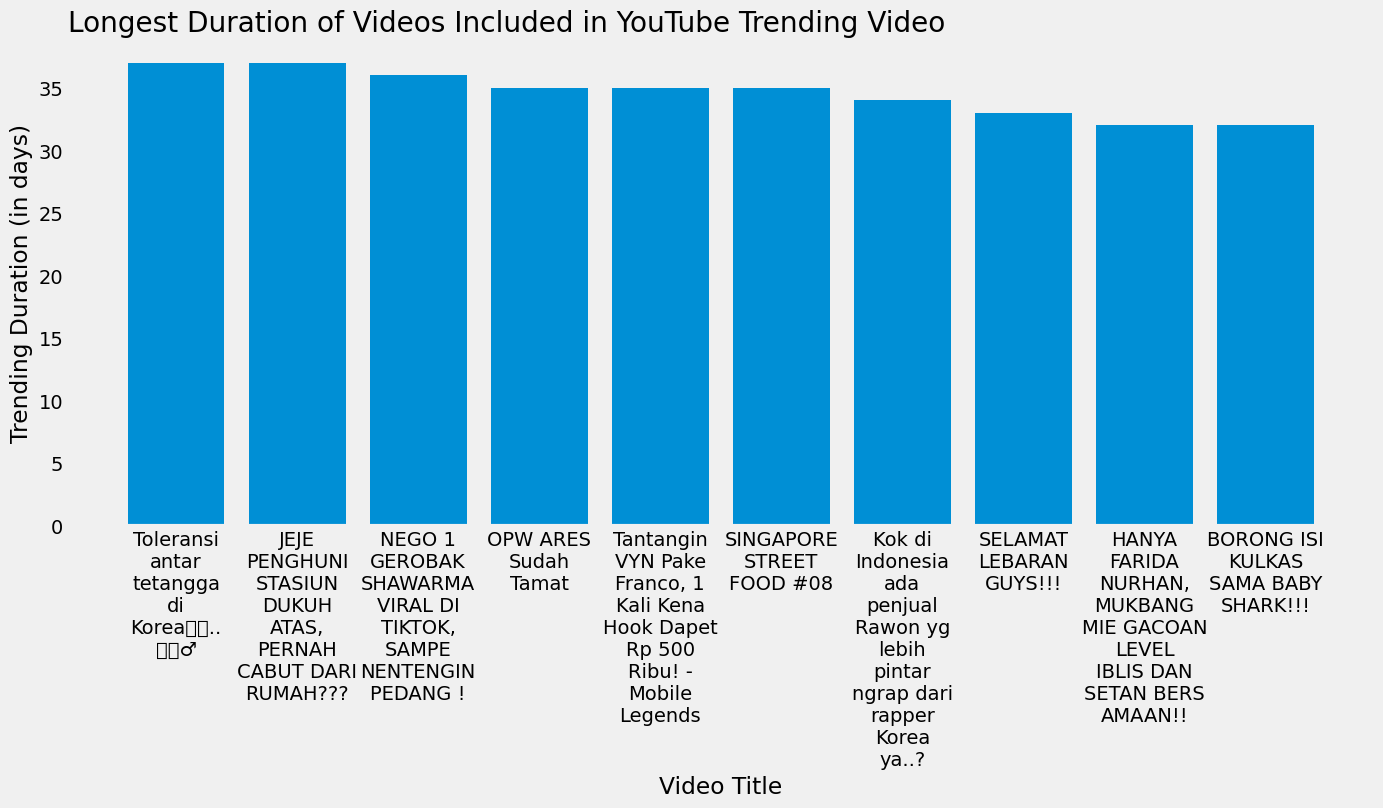

In [14]:
# Visualisasi data trending dengan chart bar
plt.figure(figsize=(15, 6))  # Perbaikan figsize

plt.bar(
    trending_duration.title[:10].apply(lambda title: "\n".join(wrap(title, width=10))),
    trending_duration.trending_duration[:10]  # Perbaikan tanda kutip
)

plt.title("Longest Duration of Videos Included in YouTube Trending Video", loc="left")
plt.xlabel("Video Title")
plt.ylabel("Trending Duration (in days)")
plt.grid(False)
plt.show()

In [15]:
trending_by_title = filtered_trending.groupby("title")
trending_rewind = trending_by_title[["view", "like", "dislike"]].agg(["min", "max", "mean", "sum"])
trending_rewind

view             \
                                                          min        max   
title                                                                      
"Awalnya Diserang Bertubi tubi" Lihatlah Bagaim...   101823.0   121044.0   
"BABY R" BIKIN GEMES !!! RAFATHAR CEMBURU, SEMU...  2280620.0  2637486.0   
"Emosi Rico Simanjutak" Saat Taisei Marukawa Be...    72434.0   116310.0   
"GUE JADI TAU ISI HATI WARISO SELAMA INI..."        1798947.0  2064042.0   
"Grebek rumah harris vriza, dan percintaannya d...    68879.0   163773.0   
...                                                       ...        ...   
🥘Yuk! Kita coba in! Let’s eat | WayV’s ONE-DAY ...   148668.0   680210.0   
🥰 New Gadgets & Versatile Utensils For Home # 2...   330156.0  7334655.0   
🥰 New Gadgets & Versatile Utensils For Home # 3...   278942.0  1212522.0   
🥰 New Gadgets & Versatile Utensils For Home # 3...   320084.0  1097903.0   
🩸괴담회에 어서오세요🩸: 첫 번째 이야기 | WELCOME TO NCT’S HORRO...  1423178.0  2966798.0   

                                                                              \
                                                            mean         sum   
title                                                                          
"Awalnya Diserang Bertubi tubi" Lihatlah Bagaim...  1.114335e+05    222867.0   
"BABY R" BIKIN GEMES !!! RAFATHAR CEMBURU, SEMU...  2.459053e+06   4918106.0   
"Emosi Rico Simanjutak" Saat Taisei Marukawa Be...  9.390625e+04    375625.0   
"GUE JADI TAU ISI HATI WARISO SELAMA INI..."        1.981122e+06  19811225.0   
"Grebek rumah harris vriza, dan percintaannya d...  1.267565e+05    760539.0   
...                                                          ...         ...   
🥘Yuk! Kita coba in! Let’s eat | WayV’s ONE-DAY ...  5.519997e+05   8831995.0   
🥰 New Gadgets & Versatile Utensils For Home # 2...  3.414214e+06  34142143.0   
🥰 New Gadgets & Versatile Utensils For Home # 3...  7.948737e+05   5564116.0   
🥰 New Gadgets & Versatile Utensils For Home # 3...  7.562497e+05   4537498.0   
🩸괴담회에 어서오세요🩸: 첫 번째 이야기 | WELCOME TO NCT’S HORRO...  2.629831e+06  36817634.0   

                                                        like            \
                                                         min       max   
title                                                                    
"Awalnya Diserang Bertubi tubi" Lihatlah Bagaim...    1336.0    1456.0   
"BABY R" BIKIN GEMES !!! RAFATHAR CEMBURU, SEMU...   93348.0  101207.0   
"Emosi Rico Simanjutak" Saat Taisei Marukawa Be...     990.0    1432.0   
"GUE JADI TAU ISI HATI WARISO SELAMA INI..."         41528.0   44699.0   
"Grebek rumah harris vriza, dan percintaannya d...    5529.0    8714.0   
...                                                      ...       ...   
🥘Yuk! Kita coba in! Let’s eat | WayV’s ONE-DAY ...   39847.0  101922.0   
🥰 New Gadgets & Versatile Utensils For Home # 2...    2822.0   58066.0   
🥰 New Gadgets & Versatile Utensils For Home # 3...    2790.0   10212.0   
🥰 New Gadgets & Versatile Utensils For Home # 3...    3025.0    8759.0   
🩸괴담회에 어서오세요🩸: 첫 번째 이야기 | WELCOME TO NCT’S HORRO...  316849.0  457809.0   

                                                                              \
                                                             mean        sum   
title                                                                          
"Awalnya Diserang Bertubi tubi" Lihatlah Bagaim...    1396.000000     2792.0   
"BABY R" BIKIN GEMES !!! RAFATHAR CEMBURU, SEMU...   97277.500000   194555.0   
"Emosi Rico Simanjutak" Saat Taisei Marukawa Be...    1228.500000     4914.0   
"GUE JADI TAU ISI HATI WARISO SELAMA INI..."         43795.800000   437958.0   
"Grebek rumah harris vriza, dan percintaannya d...    7486.833333    44921.0   
...                                                           ...        ...   
🥘Yuk! Kita coba in! Let’s eat | WayV’s ONE-DAY ...   87227.125000  1395634.0   
🥰 New Gadgets & Versatile Utensils

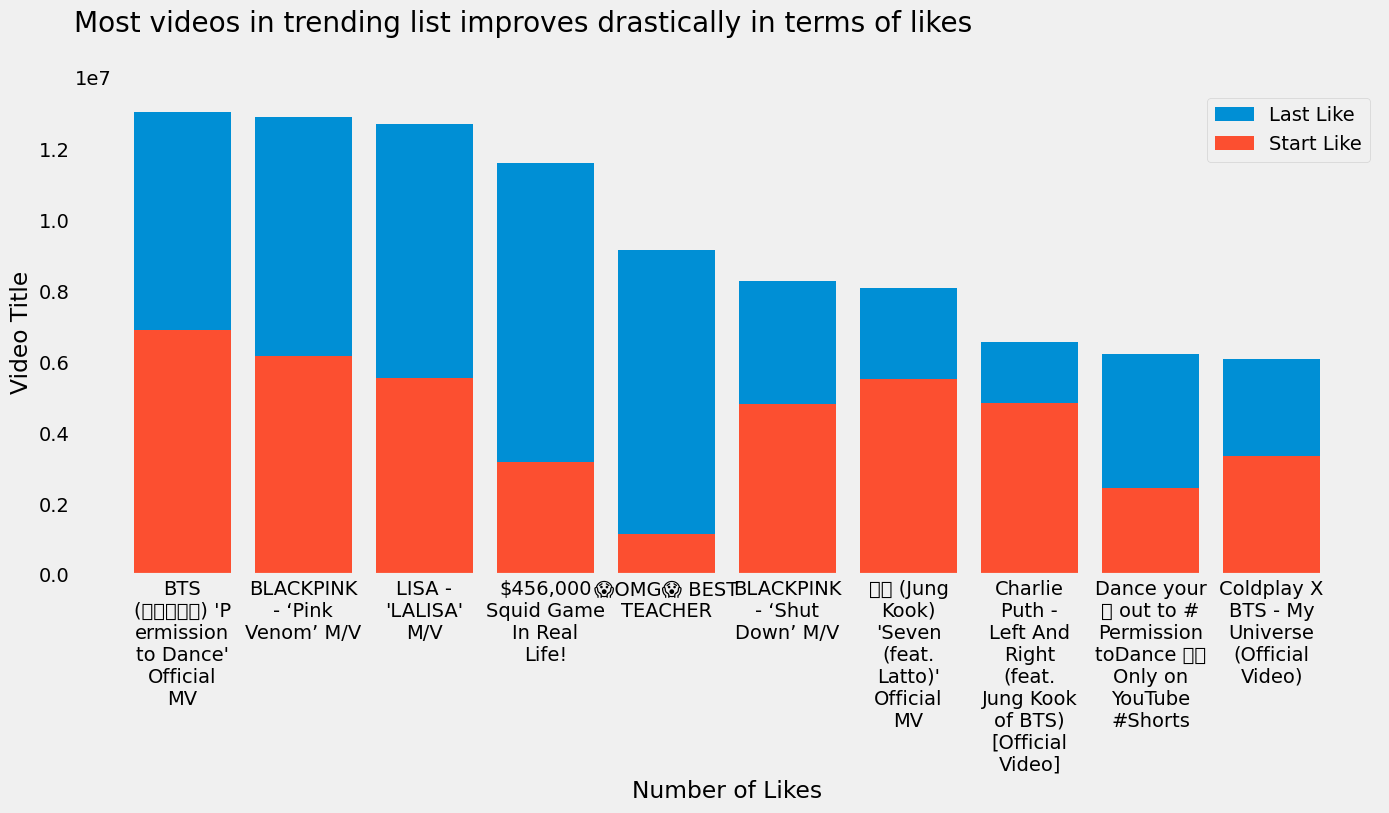

In [16]:
# Visualisai Trending video teratas masing2

top_10_liked = trending_rewind["like"].sort_values("max", ascending=False).iloc[:10]

plt.figure(figsize=(15, 6))
plt.bar(
    top_10_liked.index.to_series().apply(lambda title: "\n".join(wrap(title, width=10))),
    top_10_liked["max"],
    label="Last Like",

)
plt.bar(
    top_10_liked.index.to_series().apply(lambda title: "\n".join(wrap(title, width=10))),
    top_10_liked["min"],
    label="Start Like",

)
plt.title("Most videos in trending list improves drastically in terms of likes", loc="left", y=1.1)
plt.xlabel("Number of Likes")
plt.ylabel("Video Title")
plt.legend()
plt.grid(False)
plt.show()

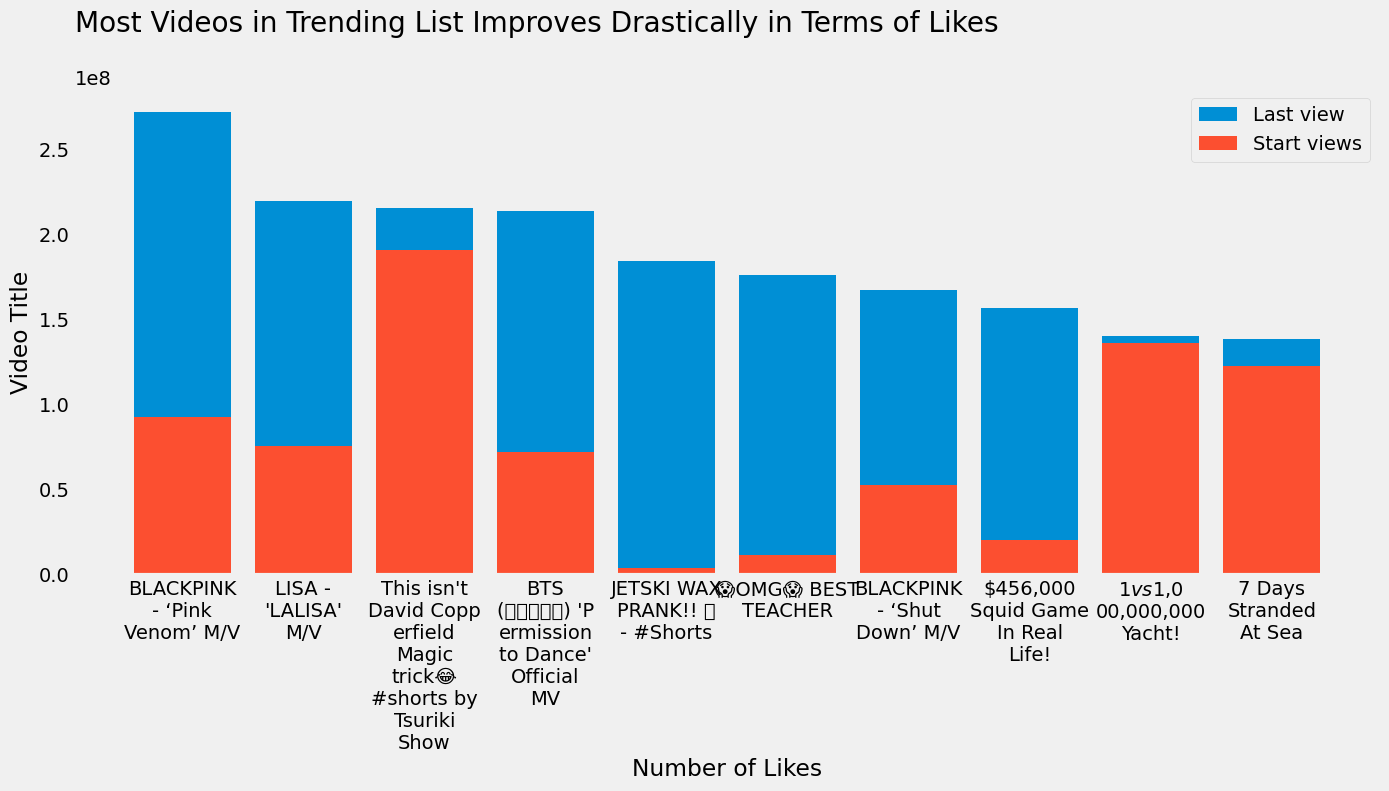

In [17]:
top_10_viewed = trending_rewind["view"].sort_values("max", ascending=False).iloc[:10]

plt.figure(figsize=(15, 6))
plt.bar(
    top_10_viewed.index.to_series().apply(lambda title: "\n".join(wrap(title, width=10))),
    top_10_viewed["max"],
    label="Last view"
)
plt.bar(
    top_10_viewed.index.to_series().apply(lambda title: "\n".join(wrap(title, width=10))),
    top_10_viewed["min"],
    label="Start views"
)
plt.title("Most Videos in Trending List Improves Drastically in Terms of Likes", loc="left", y=1.1)
plt.xlabel("Number of Likes")
plt.ylabel("Video Title")
plt.legend()
plt.grid(False)
plt.show()

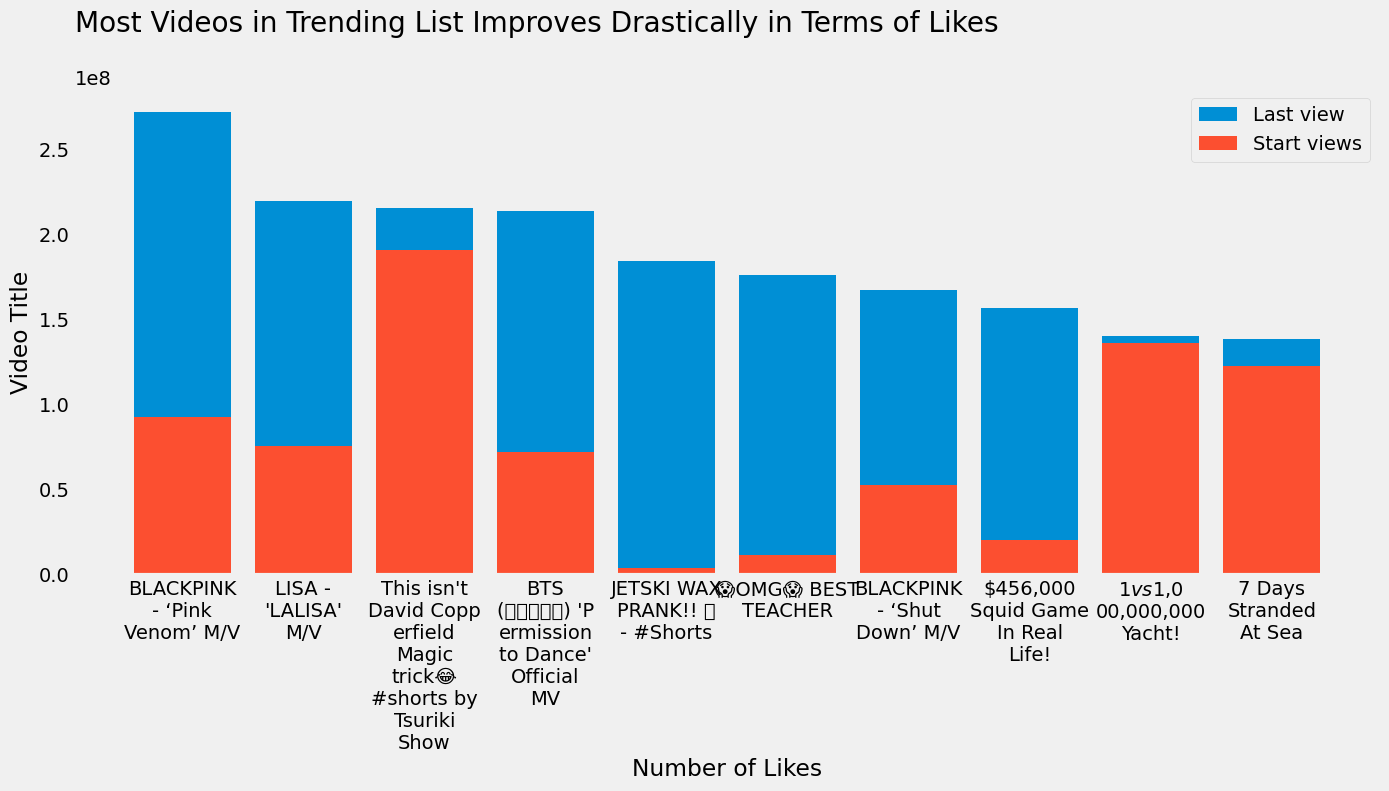

In [18]:
top_10_viewed = trending_rewind["view"].sort_values("max", ascending=False).iloc[:10]

plt.figure(figsize=(15, 6))
plt.bar(
    top_10_viewed.index.to_series().apply(lambda title: "\n".join(wrap(title, width=10))),
    top_10_viewed["max"],
    label="Last view"
)
plt.bar(
    top_10_viewed.index.to_series().apply(lambda title: "\n".join(wrap(title, width=10))),
    top_10_viewed["min"],
    label="Start views"
)
plt.title("Most Videos in Trending List Improves Drastically in Terms of Likes", loc="left", y=1.1)
plt.xlabel("Number of Likes")
plt.ylabel("Video Title")
plt.legend()
plt.grid(False)
plt.show()

In [19]:
# data preparation
!pip install langdetect

In [20]:
# Sebagai contoh, perhatikan sampel judul dan deskripsi video berikut

sample = filtered_trending.sample(10, random_state=11)
sample[["title", "description"]]

,title,description
46742,CHALLENGE MAKAN PALING HORROR! #MakanOnlineCha...,MAKAN ONLINE CHALLENGE by MAKAN ONLINE\n\nSpon...
109477,The Pangeran and Justin Show: Badmin Son Hat-t...,Son Heung-min bikin langsung bikin hattrick se...
123855,Match Highlights Persik 0 - 3 PERSIB | Pekan 1...,PERSIB meraih kemenangan 3-0 atas Persik Kedir...
32257,MASTERCHEF INDONESIA - JADI PESERTA PERTAMA YG...,Galeri 19 | Part 7\n==========================...
29932,(COVER) Andekhi Anjaani - Putri Isnari feat Ri...,(COVER)Andekhi Anjaani - Putri Isnari feat Rid...
95923,Mira Putri ft Ageng Music - TIARA (Official Li...,Official Live Music : Mira Putri ft Ageng Musi...
121702,JKT48 New Era Special Performance Video – Eure...,Eureka Milik Kita hadir dengan konsep yang ber...
43837,RACHEL VENNYA DI BACK UP SIAPA⁉️ KITA BONGKAR ...,#rachelvennya #covid #podcast
115628,KIKY SAPUTRI DILAMAR ANAK PEJABAT,Silakan komen di bawah 🖤 Kalian mau aku buat k...
46159,Yeni Inka - Top Topan (Official Music Video AN...,Title: Top Topan\nArtist: Yeni Inka\nSongwrite...


In [21]:
# Merubah title dan decripsi video menjadi lawercase

sample["title_lang"] = sample.title.apply(lambda title: langdetect.detect(title.lower()))
sample["desc_lang"] = sample.description.apply(lambda desc: langdetect.detect(desc.lower()))

In [22]:
with pd.option_context("display.max_colwidth", 100):
  display(sample[["title", "title_lang", "description", "desc_lang"]])

,title,title_lang,description,desc_lang
46742,CHALLENGE MAKAN PALING HORROR! #MakanOnlineChallenge (2/8),tl,MAKAN ONLINE CHALLENGE by MAKAN ONLINE\n\nSponsored by MS Slim by Ms Glow\n\nCHALLENGE FOOD VLOG...,id
109477,"The Pangeran and Justin Show: Badmin Son Hat-trick, Koci Gak Terkesan!",en,Son Heung-min bikin langsung bikin hattrick setelah gak mencetak gol di 8 pertandingan. Tapi Coa...,id
123855,Match Highlights Persik 0 - 3 PERSIB | Pekan 12 Liga 1 2022,id,"PERSIB meraih kemenangan 3-0 atas Persik Kediri pada pekan ke-12 Liga 1 di Stadion Manajan, Solo...",id
32257,MASTERCHEF INDONESIA - JADI PESERTA PERTAMA YG DIPANGGIL LORD ADI PANIK LAH MASA ENGGAK! | Galer...,id,Galeri 19 | Part 7\n=======================================\nPANIK GAK? PANIK GAK? PANIKLAH MASA...,id
29932,(COVER) Andekhi Anjaani - Putri Isnari feat Ridwan,id,"(COVER)Andekhi Anjaani - Putri Isnari feat Ridwan\n\nDalam proses pembuatan video ini, seluruh t...",id
95923,Mira Putri ft Ageng Music - TIARA (Official Live Music) Jika kau bertemu aku begini,id,Official Live Music : Mira Putri ft Ageng Music - Tiara\nSubscribe Global Musik Era Digital\nhtt...,id
121702,JKT48 New Era Special Performance Video – Eureka Milik Kita,da,Eureka Milik Kita hadir dengan konsep yang berbeda! Kali ini JKT48 Zee berkolaborasi dengan para...,en
43837,RACHEL VENNYA DI BACK UP SIAPA⁉️ KITA BONGKAR COBA‼️ Prof ZUBAIRI - dr TIRTA - Corbuzier Podcast,it,#rachelvennya #covid #podcast,en
115628,KIKY SAPUTRI DILAMAR ANAK PEJABAT,id,Silakan komen di bawah 🖤 Kalian mau aku buat konten apa lagi?\n\nTHANKYOU FOR 🤍\n\n- WO : @savet...,en
46159,Yeni Inka - Top Topan (Official Music Video ANEKA SAFARI) Kulo pun angkat tangan | MIQBAL GA,tl,Title: Top Topan\nArtist: Yeni Inka\nSongwriter: MIQBAL GA\n\nFollow juga kita disini yuk :\nTik...,id


In [23]:
# Pertama, kita akan membuat fungsi yang akan mendekteksi bahasa dari sebuah teks sebagai berikut:

def detect_language(text):
  """Detect language of the 'text'."""
  try:
    lang = langdetect.detect(text)
    return lang
  except:
    return

In [24]:
def detect_language(text):
  """Detect language of the 'text'."""
  try:
    lang = langdetect.detect(text)
    return lang
  except:
    return

In [25]:
filtered_trending["title_lang"] = filtered_trending["title"].apply(detect_language)
filtered_trending["desc_lang"] = filtered_trending["description"].apply(detect_language)

In [26]:
filtered_trending[["title", "title_lang", "description", "desc_lang"]]

,title,title_lang,description,desc_lang
21322,NCT DREAM 엔시티 드림 'Hello Future' MV,it,"NCT DREAM's 1st Album Repackage ""Hello Future""...",en
21323,PART 3 // SUTRISNO DAN ENDANG BAHAGIA,de,Find me on sosial media :\n\nInstagram : https...,en
21324,This isn't David Copperfield Magic trick😂 #sho...,en,Thank you for watching.\nSubscribe to Tsuriki ...,en
21325,Rizky Billar - Pemimpinmu | Official Music Video,en,Rizky Billar - Pemimpinmu | Official Music Vid...,id
21326,Ini Pengakuan Pengemudi Pajero usai Rusak dan ...,id,Polisi menangkap pengemudi SUV yang merusak da...,id
...,...,...,...,...
172342,IBT 167: A IKY BONGKAR GEBETAN BARU SULE?! TEB...,en,#sule #njan #inibukantalkshow #rizkyfebian #pu...,id
172343,Sangkolan 1 | short movie madura ( SUB INDONES...,id,Welcome to @Akeloy Production \nKali ini kami...,id
172344,BONGKAR RUMAH MASA KECILKU DI DESA WAJOK HILIR...,de,#desa #pulangkampung #yennydichina #indonesi...,id
172345,Apakah Ini KODE KERAS Zidan ‼️ Merayu Mbak Yay...,id,"KONTAK PERSON / ADMIN (KHUSUS ENDORSE, JOB, EV...",id


In [27]:
indo_trending = filtered_trending.loc[
           (filtered_trending.title_lang == "id") | (filtered_trending.desc_lang == "id")
  ]

with pd.option_context("display.max_columns", None):
  display(indo_trending.sample(10))

,video_id,publish_time,channel_id,title,description,thumbnail_url,thumbnail_width,thumbnail_height,channel_name,tags,category_id,live_status,local_title,local_description,duration,dimension,definition,caption,license_status,allowed_region,blocked_region,view,like,dislike,favorite,comment,trending_time,title_lang,desc_lang
124797,caRX4-qOMT8,2022-12-16 14:30:17+00:00,UC3J4Q1grz46bdJ7NJLd4DGw,Kemarahan Charles - Choo Choo Charles Indonesi...,Akhirnya kita sudah berhasil untuk mengumpulka...,https://i.ytimg.com/vi/caRX4-qOMT8/hqdefault.jpg,480.0,360.0,MiawAug,"['Miawaug', 'indonesia', 'Horror game', 'Choo ...",20,none,Kemarahan Charles - Choo Choo Charles Indonesi...,Akhirnya kita sudah berhasil untuk mengumpulka...,PT47M20S,2d,hd,False,True,NaN,NaN,1687944.0,57983.0,NaN,0,4996.0,2022-12-21 06:01:22.192070+00:00,en,id
110178,1wjVFXJ6SfU,2022-10-06 06:43:10+00:00,UC8rHUssNDJ9YEjfduAqJBmw,BANGKRUTIN HOTEL BINTANG 6 PERTAMA DI INDONESIA!!,"Guys,\n\nkalian pasti sering penasaran? Gmn ca...",https://i.ytimg.com/vi/1wjVFXJ6SfU/hqdefault.jpg,480.0,360.0,tanboy kun,"['tanboy kun', 'mukbang', 'makan banyak', 'ped...",24,none,BANGKRUTIN HOTEL BINTANG 6 PERTAMA DI INDONESIA!!,"Guys,\n\nkalian pasti sering penasaran? Gmn ca...",PT28M42S,2d,hd,False,True,NaN,NaN,1334913.0,40386.0,NaN,0,2555.0,2022-10-08 06:11:13.923674+00:00,de,id
27025,NaN,2021-07-25 18:00:25+00:00,UCrj0U1ZWrGiKWe4ZmjX1Tew,"MUKA SEMBAB AMANDA MANOPO, DUKA MENYELIMUTI AM...",#AmandaManopo #IbundaAmandaManopoMeniggal #Ibu...,NaN,NaN,NaN,STARPRO Indonesia,"['STARPRO', 'Infotainment', 'Obsesi', 'gosip',...",24,none,"MUKA SEMBAB AMANDA MANOPO, DUKA MENYELIMUTI AM...",#AmandaManopo #IbundaAmandaManopoMeniggal #Ibu...,PT9M17S,2d,hd,False,True,NaN,NaN,234930.0,2029.0,64.0,0,212.0,2021-07-29 06:00:56.664521+00:00,so,id
106069,J22oQ0V1V1c,2022-09-06 05:57:28+00:00,UCDjF5JQiaHh982vAgtAYCcw,"""Kulepas Dengan Ikhlas"" Versi Thailand! Versi ...",Tonton tayangan lengkap D'Academy di vidio.com...,https://i.ytimg.com/vi/J22oQ0V1V1c/hqdefault.jpg,480.0,360.0,D'Academy Indosiar,"['Dangdut Academy Indonesia', 'Dangdut Academy...",24,none,"""Kulepas Dengan Ikhlas"" Versi Thailand! Versi ...",Tonton tayangan lengkap D'Academy di vidio.com...,PT5M15S,2d,hd,False,True,NaN,NaN,334419.0,7059.0,NaN,0,446.0,2022-09-17 06:04:20.810817+00:00,id,id
94905,8kJsncH6t-s,2022-06-29 09:00:27+00:00,UCjTA5AcXGsksWEZkRvFO8mA,MENCURI RADEN SALEH - OFFICIAL TRAILER 1 | TAY...,"Berawal dari keadaan mendesak, yakni ""Butuh Ua...",https://i.ytimg.com/vi/8kJsncH6t-s/hqdefault.jpg,480.0,360.0,Visinema Pictures,"['visinema', 'visinema pictures', 'mencuri rad...",1,none,MENCURI RADEN SALEH - OFFICIAL TRAILER 1 | TAY...,"Berawal dari keadaan mendesak, yakni ""Butuh Ua...",PT1M45S,2d,hd,False,True,NaN,NaN,1097660.0,9513.0,NaN,0,846.0,2022-07-20 06:01:00.748756+00:00,de,id
44502,NaN,2021-10-22 22:07:00+00:00,UC24_Z2L-8Ki183AI9zJJzNQ,Aksi PEMBAJAKAN BUS Yang Menegangkan | LAPOR P...,"LAPOR PAK!\nJumat, 22 Oktober 2021\n\nPART 1 :...",NaN,NaN,NaN,TRANS7 OFFICIAL,"['TRANS7', 'TRANSMEDIA', 'TRANS7 LIVESTREAMING...",24,none,Aksi PEMBAJAKAN BUS Yang Menegangkan | LAPOR P...,"LAPOR PAK!\nJumat, 22 Oktober 2021\n\nPART 1 :...",PT14M58S,2d,hd,False,True,NaN,NaN,494904.0,9485.0,223.0,0,569.0,2021-10-24 06:00:45.794378+00:00,id,en
40012,NaN,2021-09-30 11:20:50+00:00,UCFuM3BWlLM3YbLjkXBiJ8-A,COBAIN ES KRIM VIRAL TIKTOK! FT. JESS NO LIMIT,Social Media:\nhttps://www.youtube.com/jessica...,NaN,NaN,NaN,Jessica Jane,"['JESSICA JANE', 'JESIKA JANE', '24 JAM JESSIC...",24,none,COBAIN ES KRIM VIRAL TIKTOK! FT. JESS NO LIMIT,Social Media:\nhttps://www.youtube.com/jessica...,PT16M46S,2d,hd,False,True,NaN,NaN,933378.0,66928.0,577.0,0,2904.0,2021-10-02 06:00:46.151795+00:00,en,id
120264,GEuomyhI8NE,2022-11-18 09:00:10+00:00,UCmiJjv8BbzLahKpsfkQaBnA,Arief - Tolong Jaga Perasaanku (Official Music...,Music & Video Credits:\nArtist: Arief\nTitle: ...,https://i.ytimg.com/vi/GEuomyhI8NE/hqdefault.jpg,480.0,360.0,Arief Putra,"['arief musik', 'arief putra',

In [28]:
indo_trending = filtered_trending.loc[
           (filtered_trending.title_lang == "id") | (filtered_trending.desc_lang == "id")
  ]

with pd.option_context("display.max_columns", None):
  display(indo_trending.sample(10))

,video_id,publish_time,channel_id,title,description,thumbnail_url,thumbnail_width,thumbnail_height,channel_name,tags,category_id,live_status,local_title,local_description,duration,dimension,definition,caption,license_status,allowed_region,blocked_region,view,like,dislike,favorite,comment,trending_time,title_lang,desc_lang
119451,uMr5MyNhpfQ,2022-11-16 08:15:01+00:00,UChFRHojUZJ9KfC4SHcN5wZA,Luna Marah! Iko Mengacau!! (2/4),PART 1 : https://youtu.be/IoKncVkmzlY\nPART 2 ...,https://i.ytimg.com/vi/uMr5MyNhpfQ/hqdefault.jpg,480.0,360.0,Indonesia's Next Top Models,"['net', 'media', 'netmedia', 'netmediatama', '...",10,none,Luna Marah! Iko Mengacau!! (2/4),PART 1 : https://youtu.be/IoKncVkmzlY\nPART 2 ...,PT16M18S,2d,hd,False,True,['ID'],NaN,618616.0,11303.0,NaN,0,1141.0,2022-11-23 06:01:32.474584+00:00,id,id
98677,dkpYrmxZf2w,2022-07-22 08:10:06+00:00,UC7yjilLM475fpi_nQUAQ2tQ,PERTAMA KALI DRIFTING DI SITINJAU LAUIK,"hi guys,\nKali ini gue mau menjawab DM dari ka...",https://i.ytimg.com/vi/dkpYrmxZf2w/hqdefault.jpg,480.0,360.0,Akbar Rais,"['akbar rais', 'mobil balap', 'drift', 'drifti...",2,none,PERTAMA KALI DRIFTING DI SITINJAU LAUIK,"hi guys,\nKali ini gue mau menjawab DM dari ka...",PT8M24S,2d,hd,False,True,NaN,NaN,324695.0,11279.0,NaN,0,857.0,2022-08-11 06:01:46.800429+00:00,de,id
57326,RgXXkUxnKrQ,2021-12-29 09:00:10+00:00,UCl0AXmYD5-9ZwQfafFi81ZA,"Not Only One, Semua Judges Kompak Beri Tiga Ye...",IT'S TIME TO FACE THE MUSIC!!! \n\nThis is X F...,https://i.ytimg.com/vi/RgXXkUxnKrQ/hqdefault.jpg,480.0,360.0,X Factor Indonesia,"['xfactor', 'indonesia', 'factor', 'singing', ...",24,none,"Not Only One, Semua Judges Kompak Beri Tiga Ye...",IT'S TIME TO FACE THE MUSIC!!! \n\nThis is X F...,PT5M16S,2d,hd,False,True,NaN,NaN,1032938.0,18432.0,NaN,0,1231.0,2021-12-30 06:01:01.849876+00:00,id,en
40102,NaN,2021-09-25 12:00:09+00:00,UCa3k1_nfBeXbf7be6Dcy_vQ,Tiga Kunti Dalam Satu Sosok – DMS [ Penelusuran ],“ Kami tidak memaksakan apa yang kami percaya ...,NaN,NaN,NaN,Sara Wijayanto,['sara wijayanto sara demian demian sara wijay...,22,none,Tiga Kunti Dalam Satu Sosok – DMS [ Penelusuran ],“ Kami tidak memaksakan apa yang kami percaya ...,PT1H35M51S,2d,hd,False,True,NaN,NaN,2187910.0,91226.0,1359.0,0,5695.0,2021-10-02 06:00:46.152489+00:00,id,id
103325,AYpOXEfWmq0,2022-08-17 08:00:13+00:00,UCLLGM0MV2OpvwFCjG70nkIg,Ndarboy Genk - Indonesia Bakoh (Official Musi...,Ndarboy Genk - Indonesia Bakoh (Official Vide...,https://i.ytimg.com/vi/AYpOXEfWmq0/hqdefault.jpg,480.0,360.0,Ndarboy Genk,"['Ndarboy Genk', 'Ndarboy', 'ndarboy genk indo...",10,none,Ndarboy Genk - Indonesia Bakoh (Official Musi...,Ndarboy Genk - Indonesia Bakoh (Official Vide...,PT5M45S,2d,hd,False,True,NaN,NaN,493533.0,15489.0,NaN,0,1630.0,2022-09-03 06:01:05.051470+00:00,en,id
171629,OU0uojTV5NA,2023-08-19 02:12:20+00:00,UC7GWXKxiy9_AU9TytEh00eg,Misteri Hantu Farida 1 - Suka kasih Hadiah & M...,Gabung membership untuk mendukung animator lok...,https://i.ytimg.com/vi/OU0uojTV5NA/hqdefault.jpg,480.0,360.0,Rizky Riplay,"['hantu', 'kartun hantu', 'kartun horror', 'ka...",1,none,Misteri Hantu Farida 1 - Suka kasih Hadiah & M...,Gabung membership untuk mendukung animator lok...,PT9M19S,2d,hd,False,True,NaN,NaN,1205489.0,27809.0,NaN,0,2724.0,2023-08-29 09:16:45.738117+00:00,id,id
93628,HFyxrcit-WE,2022-06-17 06:00:09+00:00,UCepgnl-TtJ8DurHdC6EE22w,HELLO BATAM #03,Hello!\nHolla!\nHi~\n\nKalian sedang apa?\nKok...,https://i.ytimg.com/vi/HFyxrcit-WE/hqdefault.jpg,480.0,360.0,Ria SW,NaN,24,none,HELLO BATAM #03,Hello!\nHolla!\nHi~\n\nKalian sedang apa?\nKok...,PT19M23S,2d,hd,False,True,NaN,NaN,1567193.0,86047.0,NaN,0,2321.0,2022-07-12 06:01:20.252722+00:00,en,id
57214,4kzKmPFtzXI,2021-12-20 08:28:11+00:00,UCpAZ8Wsj4MlE1M2vLds_u1Q,DRAMA BU GURU MELAHIRKAN DI SEKOLAH - Part 1,Tonton DRAMA BU GURU MELAHIRKAN PART 2nya disi...,https://i.ytimg.com/vi/4kzKmPFtzXI/hqdefault.jpg,480.0,360.0,RICHKYI,NaN,23,none,DRAMA BU GURU MELAHIRKAN DI SEKOLAH - Part 1,Tonton DRAMA BU GURU MELAHIRKAN PART 2nya disi

In [29]:
data = indo_trending[["title", "description", "category_id"]].reset_index(drop=True)
data

,title,description,category_id
0,Rizky Billar - Pemimpinmu | Official Music Video,Rizky Billar - Pemimpinmu | Official Music Vid...,10
1,Ini Pengakuan Pengemudi Pajero usai Rusak dan ...,Polisi menangkap pengemudi SUV yang merusak da...,25
2,Aksi Demo Tolak Kedatangan Jokowi di Kendari B...,Tanggal Tayang: 30/06/2021\n\nProgram berita h...,25
3,"PERTAMA KALI LIAT SAPI SEGEDE GINI, DINAIKIN D...",Assalamualaikum gaeess..! sudah nonton video s...,15
4,PODKESMAS SAMPAI GA NYAMAN DIBAHAS DISINI - To...,Talk show malam yang akan memberikan informasi...,24
...,...,...,...
49235,IBT 167: A IKY BONGKAR GEBETAN BARU SULE?! TEB...,#sule #njan #inibukantalkshow #rizkyfebian #pu...,24
49236,Sangkolan 1 | short movie madura ( SUB INDONES...,Welcome to @Akeloy Production \nKali ini kami...,24
49237,BONGKAR RUMAH MASA KECILKU DI DESA WAJOK HILIR...,#desa #pulangkampung #yennydichina #indonesi...,22
49238,Apakah Ini KODE KERAS Zidan ‼️ Merayu Mbak Yay...,"KONTAK PERSON / ADMIN (KHUSUS ENDORSE, JOB, EV...",10


In [30]:
data.drop_duplicates(subset="title", inplace=True)

In [31]:
data.reset_index(drop=True, inplace=True)
data.shape

(7455, 3)

In [32]:
# Install Emoji

!pip install emoji

In [33]:
list_emoji = [e for e in emoji.EMOJI_DATA]

count = 0
for em in list_emoji:
  for title in data.title:
    if em in title:
      count += 1
print("How many titles use emoji?", count)

How many titles use emoji? 1035


In [34]:
def demojize(text):
  for em in list_emoji:
    if em in text:
      em_text = emoji.demojize(em)
      text = text.replace(em, " " + em_text + " ")
      return text

In [35]:
def demojize(text):
  for em in list_emoji:
    if em in text:
      em_text = emoji.demojize(em)
      text = text.replace(em, " " + em_text + " ")
      return text

In [36]:
data["title_emoji"] = data.title.apply(demojize)

In [37]:
title_with_emoji_idx =[
    idx for idx in range(len(data.title))
    for em in list_emoji
    if em in data.loc[idx, "title"]
]

In [38]:
with pd.option_context("display.max_colwidth", 100):
  display(data.loc[title_with_emoji_idx])

,title,description,category_id,title_emoji
33,Dari Jendela Smp : GREGETTT...Wih kelihatannya Wulan jadi primadona di SMA Merdeka Mandiri nih...❤,Saksikan #DariJendelaSMP Setiap Hari Pkl. 16.40 WIB hanya di @Surya Citra Televisi (SCTV) \n@sin...,24,Dari Jendela Smp : GREGETTT...Wih kelihatannya Wulan jadi primadona di SMA Merdeka Mandiri nih.....
78,BIKIN CEWEK TERPESONA 😍 Aksi Heroik Driver Muda Menolong Sopir Yang Kesulitan di Sitinjau Lauik,Aksi heroik driver muda membantu sopir minibus yang kesulitan di Sitinjau Lauik\n\ninstagram : h...,2,BIKIN CEWEK TERPESONA :smiling_face_with_heart-eyes: Aksi Heroik Driver Muda Menolong Sopir Ya...
79,15 MENIT MEMBAKAR LEMAK 1 Kg !!! 24 Jam TIMBANGAN TURUN ✅ ✅ ✅,"15 menit membakar lemak, ok ! siapa yg workout mengharapkan bisa membakar 1 kg lemak dalam 15 me...",26,15 MENIT MEMBAKAR LEMAK 1 Kg !!! 24 Jam TIMBANGAN TURUN :check_mark_button: :check_mark_butto...
148,"WHY‼️ SAYA DISOMASI, TOLOOONG...- Deddy Corbuzier Podcast","#somasi #odgj #podcast\nTEMAN TEMAN KONTEN CREATOR, JANGAN TAKUT BERKARYA SELAMA TUJUAN KALIAN B...",24,"WHY :double_exclamation_mark: SAYA DISOMASI, TOLOOONG...- Deddy Corbuzier Podcast"
148,"WHY‼️ SAYA DISOMASI, TOLOOONG...- Deddy Corbuzier Podcast","#somasi #odgj #podcast\nTEMAN TEMAN KONTEN CREATOR, JANGAN TAKUT BERKARYA SELAMA TUJUAN KALIAN B...",24,"WHY :double_exclamation_mark: SAYA DISOMASI, TOLOOONG...- Deddy Corbuzier Podcast"
...,...,...,...,...
7434,STANDUPFEST 2023 Extended Version dari The Founders 🥳🥳 - Lucu Terus Nih,"Host yang ada di video ini, Arie Kriting, mau bikin special show! Judulnya ILMU HITAM! Beli tike...",22,STANDUPFEST 2023 Extended Version dari The Founders :partying_face: :partying_face: - Lucu Te...
7435,BOY UDAH AJAK AYU TING-TING KE RUMAH BARU?😝,"Hai guys... welcome back in my youtube channel, kali ini aku mau ngajakin ngobrol BOY WILLIAM ni...",22,BOY UDAH AJAK AYU TING-TING KE RUMAH BARU? :squinting_face_with_tongue:
7437,ADA PACAR!?!?😉NGOBROL TENTANG GOSIP🇮🇩 SAMBIL MAKAN NASI PADANG SAMA KAK HARUKA,"HALO GUYS, OHAYOU KONNICHIWA KONBANWA!!! AKU YUSUKE!!! video kali ini, kita aku sama kak haruka ...",22,ADA PACAR!?!?😉NGOBROL TENTANG GOSIP :Indonesia: SAMBIL MAKAN NASI PADANG SAMA KAK HARUKA
7437,ADA PACAR!?!?😉NGOBROL TENTANG GOSIP🇮🇩 SAMBIL MAKAN NASI PADANG SAMA KAK HARUKA,"HALO GUYS, OHAYOU KONNICHIWA KONBANWA!!! AKU YUSUKE!!! video kali ini, kita aku sama kak haruka ...",22,ADA PACAR!?!?😉NGOBROL TENTANG GOSIP :Indonesia: SAMBIL MAKAN NASI PADANG SAMA KAK HARUKA


In [39]:
# Delete kolom title

data.drop(columns="title", inplace=True)

In [40]:
desc_with_emoji_idx = [
    idx for idx in range(len(data.description))
    for em in list_emoji
    if em in data.loc[idx, "description"]
]

data["desc_emoji"] = data.description.apply(demojize)

with pd.option_context("display.max_colwidth", 100):
  display(data.loc[desc_with_emoji_idx])

,description,category_id,title_emoji,desc_emoji
0,Rizky Billar - Pemimpinmu | Official Music Video\n\nSurprise Untuk Dede Lesti :\nhttps://youtu.b...,10,None,Rizky Billar - Pemimpinmu | Official Music Video\n\nSurprise Untuk Dede Lesti :\nhttps://youtu.b...
10,"Title: Sempurnakan Hariku \nArtist: Rey Mbayang\nComposser: Rey Mbayang, Trakast\nMusic Arranger...",10,None,"Title: Sempurnakan Hariku \nArtist: Rey Mbayang\nComposser: Rey Mbayang, Trakast\nMusic Arranger..."
11,Title: Apa Kabar Mantan\nArtist: Yeni Inka\nSongwriter: Yonanda NDX\n\nFollow juga kita disini y...,10,None,Title: Apa Kabar Mantan\nArtist: Yeni Inka\nSongwriter: Yonanda NDX\n\nFollow juga kita disini y...
11,Title: Apa Kabar Mantan\nArtist: Yeni Inka\nSongwriter: Yonanda NDX\n\nFollow juga kita disini y...,10,None,Title: Apa Kabar Mantan\nArtist: Yeni Inka\nSongwriter: Yonanda NDX\n\nFollow juga kita disini y...
13,#ByoodeJanganCobaCoba #Byoode #MusicVideo #Girlband #Dangdut\n\nDengerin lagu Byoode - Jangan Co...,10,None,#ByoodeJanganCobaCoba #Byoode #MusicVideo #Girlband #Dangdut\n\nDengerin lagu Byoode - Jangan Co...
...,...,...,...,...
7442,#sie_em\n\n__________________________________________________\nThanks for watching\n\nSUBSCRIBE ...,22,None,#sie_em\n\n__________________________________________________\nThanks for watching\n\nSUBSCRIBE ...
7444,#lunamaya #birthday \n\nPRODUK NIKITA SLIM/NIKITA MIRZANI SKINCARE BISA DIORDER DISINI YAA ⤵️⤵️\...,22,None,#lunamaya #birthday \n\nPRODUK NIKITA SLIM/NIKITA MIRZANI SKINCARE BISA DIORDER DISINI YAA :rig...
7444,#lunamaya #birthday \n\nPRODUK NIKITA SLIM/NIKITA MIRZANI SKINCARE BISA DIORDER DISINI YAA ⤵️⤵️\...,22,None,#lunamaya #birthday \n\nPRODUK NIKITA SLIM/NIKITA MIRZANI SKINCARE BISA DIORDER DISINI YAA :rig...
7453,Thank you for watching! Don't forget to like & comment!\n\n✧･ﾟ: *✧･ﾟ:* *:･ﾟ✧*:･ﾟ✧\n\n♱ Socials :...,20,Q&A sambil makan PADANG di Pasar Senen ft. Jessica Jane :drooling_face:,Thank you for watching! Don't forget to like & comment!\n\n✧･ﾟ: *✧･ﾟ:* *:･ﾟ✧*:･ﾟ✧\n\n♱ Socials :...


In [41]:
data.drop(columns="description", inplace=True)

In [42]:
data["all_text"] = data["title_emoji"] + " " + data["desc_emoji"]

In [43]:
# data split
X_train, X_dev, y_train, y_dev = train_test_split(
    data["all_text"], data["category_id"],
    test_size=.2,
    stratify=data["category_id"],
    random_state=11
)

# Before vectorizing, fill NaN values in 'all_text' with empty strings:
X_train = X_train.fillna('')
X_dev = X_dev.fillna('')

training_size = X_train.shape[0]
dev_size = X_dev.shape[0]

print(f"training_size = {training_size} .. dev_size = {dev_size}")

# define vectorizer
vectorizer = TfidfVectorizer(
    min_df=.015,
    max_df=.7,
    ngram_range=(1, 1),
)

# generate tf-idf matrix
train_tfidf = vectorizer.fit_transform(X_train)
dev_tfidf = vectorizer.transform(X_dev)
print("Got train tf-idf with shape:", train_tfidf.shape)
print("Got dev tf-idf with shape:", dev_tfidf.shape)

# convert to dataframe
train_tfidf = pd.DataFrame(train_tfidf.toarray(), columns=vectorizer.get_feature_names_out())
dev_tfidf = pd.DataFrame(dev_tfidf.toarray(), columns=vectorizer.get_feature_names_out())

training_size = 5964 .. dev_size = 1491
Got train tf-idf with shape: (5964, 17)
Got dev tf-idf with shape: (1491, 17)


In [44]:
with pd.option_context("display.max_columns", 100):
  display(train_tfidf.sample(5))

,bit,channel,dan,dengan,di,facebook,https,indonesia,instagram,ly,official,subscribe,twitter,untuk,www,yang,youtube
4077,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5071,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1869,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1691,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2115,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
dict_models = {
    "logistic_regression": LogisticRegression(),
    "naive_bayes": MultinomialNB(),
    "svm": LinearSVC(random_state=11),
    "decision_tree": DecisionTreeClassifier(random_state=11),
    "random_forest": RandomForestClassifier(random_state=11)
}

In [46]:
for model in dict_models.values():
  print("-- {} --".format(model.__class__.__name__)) # Use .format() for compatibility
  model.fit(train_tfidf, y_train)
  y_pred = model.predict(dev_tfidf)
  print("Report on dev set:", classification_report(y_dev, y_pred), sep="\n")

-- LogisticRegression --
Report on dev set:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        54
           2       0.00      0.00      0.00        45
          10       0.00      0.00      0.00       275
          15       0.00      0.00      0.00        14
          17       0.00      0.00      0.00        67
          19       0.00      0.00      0.00         9
          20       0.60      0.04      0.07       151
          22       0.67      0.04      0.07       152
          23       0.00      0.00      0.00        48
          24       0.33      0.99      0.49       486
          25       0.00      0.00      0.00       126
          26       0.00      0.00      0.00        20
          27       0.00      0.00      0.00        12
          28       0.00      0.00      0.00        20
          29       0.00      0.00      0.00        12

    accuracy                           0.33      1491
   macro avg       0.11      0.07   

In [47]:
svm_grid_search = GridSearchCV(
    dict_models["svm"], # Access the 'svm' model using square brackets
    {"C": (10, 1, .1, .05, .01)},
)

svm_grid_search.fit(train_tfidf, y_train)
svm_pred_dev = svm_grid_search.predict(dev_tfidf)
print("Report on train set:",
      classification_report(
          y_train,
          svm_grid_search.predict(train_tfidf)
      ), sep="\n")
print("Reports on dev set:", classification_report(y_dev, svm_pred_dev), sep="\n")



Report on train set:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       219
           2       0.00      0.00      0.00       181
          10       0.00      0.00      0.00      1103
          15       0.00      0.00      0.00        54
          17       0.00      0.00      0.00       270
          19       1.00      0.03      0.06        34
          20       0.67      0.04      0.08       602
          22       0.73      0.03      0.06       608
          23       0.00      0.00      0.00       192
          24       0.33      0.99      0.49      1943
          25       0.88      0.01      0.03       504
          26       0.00      0.00      0.00        79
          27       0.00      0.00      0.00        49
          28       0.00      0.00      0.00        79
          29       0.00      0.00      0.00        47

    accuracy                           0.33      5964
   macro avg       0.24      0.07      0.05      5964
weigh

In [48]:
svm_grid_search.best_params_

{'C': 1}

In [49]:
random_forest_grid_search = GridSearchCV(
    dict_models["random_forest"],
    {"n_estimators": (10, 20, 25, 50, 75, 100, 125),
    "max_depth": (5, 10, 25, 50),
     }

)

random_forest_grid_search.fit(train_tfidf, y_train)
random_forest_pred = random_forest_grid_search.predict(dev_tfidf)
print("Reports on train set:",
      classification_report(
          y_train,
          random_forest_grid_search.predict(train_tfidf)
      ),
      sep="\n"
      )
print("Reports on dev set:", classification_report(y_dev, random_forest_pred), sep="\n")

Reports on train set:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       219
           2       1.00      0.01      0.01       181
          10       1.00      0.00      0.00      1103
          15       1.00      0.02      0.04        54
          17       1.00      0.01      0.03       270
          19       1.00      0.03      0.06        34
          20       1.00      0.04      0.08       602
          22       1.00      0.04      0.08       608
          23       1.00      0.01      0.01       192
          24       0.33      1.00      0.50      1943
          25       1.00      0.01      0.03       504
          26       0.00      0.00      0.00        79
          27       0.00      0.00      0.00        49
          28       1.00      0.03      0.05        79
          29       0.00      0.00      0.00        47

    accuracy                           0.34      5964
   macro avg       0.69      0.08      0.06      5964
weig

In [50]:
random_forest_grid_search.best_params_

{'max_depth': 25, 'n_estimators': 25}

In [51]:
model = Pipeline([
    ("vectorizer", TfidfVectorizer(
        min_df=.015,
        max_df=.7,
        ngram_range=(1, 1),
    )),
    ("model", RandomForestClassifier(
        max_depth=50,
        n_estimators=75,
        random_state=11
    ))
])

# Training
model.fit(X_train, y_train)

pred = model.predict(X_dev)
print("Reports on train set:",
      classification_report(
          y_train,
          model.predict(X_train)
      ),
      sep="\n"
)
print("Reports on dev set:", classification_report(y_dev, pred), sep="\n")

Reports on train set:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       219
           2       1.00      0.01      0.01       181
          10       1.00      0.00      0.00      1103
          15       1.00      0.02      0.04        54
          17       1.00      0.01      0.03       270
          19       1.00      0.03      0.06        34
          20       1.00      0.04      0.08       602
          22       1.00      0.04      0.08       608
          23       1.00      0.01      0.01       192
          24       0.33      1.00      0.50      1943
          25       1.00      0.01      0.03       504
          26       0.00      0.00      0.00        79
          27       0.00      0.00      0.00        49
          28       1.00      0.03      0.05        79
          29       0.00      0.00      0.00        47

    accuracy                           0.34      5964
   macro avg       0.69      0.08      0.06      5964
weig

In [52]:
joblib.dump(model, '//content/Latihan_7_ke_2_risma.joblib')

# Muat kembali model
loaded_model = joblib.load('Latihan_7_ke_2_risma.joblib')
print(loaded_model.get_params())

{'memory': None, 'steps': [('vectorizer', TfidfVectorizer(max_df=0.7, min_df=0.015)), ('model', RandomForestClassifier(max_depth=50, n_estimators=75, random_state=11))], 'transform_input': None, 'verbose': False, 'vectorizer': TfidfVectorizer(max_df=0.7, min_df=0.015), 'model': RandomForestClassifier(max_depth=50, n_estimators=75, random_state=11), 'vectorizer__analyzer': 'word', 'vectorizer__binary': False, 'vectorizer__decode_error': 'strict', 'vectorizer__dtype': <class 'numpy.float64'>, 'vectorizer__encoding': 'utf-8', 'vectorizer__input': 'content', 'vectorizer__lowercase': True, 'vectorizer__max_df': 0.7, 'vectorizer__max_features': None, 'vectorizer__min_df': 0.015, 'vectorizer__ngram_range': (1, 1), 'vectorizer__norm': 'l2', 'vectorizer__preprocessor': None, 'vectorizer__smooth_idf': True, 'vectorizer__stop_words': None, 'vectorizer__strip_accents': None, 'vectorizer__sublinear_tf': False, 'vectorizer__token_pattern': '(?u)\\b\\w\\w+\\b', 'vectorizer__tokenizer': None, 'vectori

In [53]:
preds = model.predict(X_dev)
print(classification_report(y_dev, preds))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        54
           2       0.00      0.00      0.00        45
          10       0.00      0.00      0.00       275
          15       0.00      0.00      0.00        14
          17       1.00      0.03      0.06        67
          19       0.00      0.00      0.00         9
          20       0.70      0.05      0.09       151
          22       0.75      0.04      0.07       152
          23       0.00      0.00      0.00        48
          24       0.33      1.00      0.50       486
          25       0.00      0.00      0.00       126
          26       0.00      0.00      0.00        20
          27       0.00      0.00      0.00        12
          28       0.00      0.00      0.00        20
          29       0.00      0.00      0.00        12

    accuracy                           0.34      1491
   macro avg       0.19      0.07      0.05      1491
weighted avg       0.30   

Latihan Text Processing

In [54]:
import pandas as pd

df = pd.DataFrame({
    'country': ['India', 'US', 'Japan', 'Japan', 'US', 'Japan'],
    'age': [44, 34, 46, 35, 23, None],  # Added None to match length
    'salary': [72000, 65000, 98000, 45000, 34000, None]  # Added None to match length
})

df

,country,age,salary
0,India,44.0,72000.0
1,US,34.0,65000.0
2,Japan,46.0,98000.0
3,Japan,35.0,45000.0
4,US,23.0,34000.0
5,Japan,NaN,NaN


In [55]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['country'] = label_encoder.fit_transform(df['country'])
df

,country,age,salary
0,0,44.0,72000.0
1,2,34.0,65000.0
2,1,46.0,98000.0
3,1,35.0,45000.0
4,2,23.0,34000.0
5,1,NaN,NaN


In [56]:
label_encoder.classes_

array(['India', 'Japan', 'US'], dtype=object)

In [57]:
X = df['country'].values.reshape(-1,1)
X

array([[0],
       [2],
       [1],
       [1],
       [2],
       [1]])

In [58]:
from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder()
X = onehot_encoder.fit_transform(X).toarray()
X

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.]])

In [59]:
onehot_encoder.categories_

[array([0, 1, 2])]

In [60]:
# Membuat DataFrame baru dari hasil one-hot encoding
df_onehot = pd.DataFrame(X, columns=[str(i) for i in range(X.shape[1])])
df_onehot

# Menggabungkan DataFrame hasil one-hot encoding dengan DataFrame asli
df = pd.concat([df_onehot, df], axis=1)
df

# Menghapus kolom 'country' dari DataFrame karena sudah dienkode
df = df.drop(['country'], axis=1)
df

,0,1,2,age,salary
0,1.0,0.0,0.0,44.0,72000.0
1,0.0,0.0,1.0,34.0,65000.0
2,0.0,1.0,0.0,46.0,98000.0
3,0.0,1.0,0.0,35.0,45000.0
4,0.0,0.0,1.0,23.0,34000.0
5,0.0,1.0,0.0,NaN,NaN


In [61]:
corpus = [
    'The Industrial Revolution 4.0 is changing most of the business activities',
    'The Industrial Revolution 4.0 has five technologies that are the main points',
    'Industry 4.0 opens new challenges for companies'
]

corpus

['The Industrial Revolution 4.0 is changing most of the business activities',
 'The Industrial Revolution 4.0 has five technologies that are the main points',
 'Industry 4.0 opens new challenges for companies']

In [62]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer_X = vectorizer.fit_transform(corpus).todense()
vectorizer_X

matrix([[1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0,
         2],
        [0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1,
         2],
        [0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
         0]])

In [63]:
vectorizer.get_feature_names_out()

array(['activities', 'are', 'business', 'challenges', 'changing',
       'companies', 'five', 'for', 'has', 'industrial', 'industry', 'is',
       'main', 'most', 'new', 'of', 'opens', 'points', 'revolution',
       'technologies', 'that', 'the'], dtype=object)

In [64]:
from sklearn.metrics.pairwise import euclidean_distances

for i in range(len(vectorizer_X)):
    for j in range(i, len(vectorizer_X)):
        if i == j:
            continue
        # Convert matrix slices to arrays before calculating distance
        jarak = euclidean_distances(np.asarray(vectorizer_X[i]), np.asarray(vectorizer_X[j]))
        print(f'Jarak dokumen {i+1} dan {j+1}: {jarak}')

Jarak dokumen 1 dan 2: [[3.60555128]]
Jarak dokumen 1 dan 3: [[4.24264069]]
Jarak dokumen 2 dan 3: [[4.35889894]]


In [65]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english')
vectorizer_X = vectorizer.fit_transform(corpus).todense()
vectorizer_X

matrix([[1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1],
        [0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0]])

In [66]:
vectorizer.get_feature_names_out()

array(['activities', 'business', 'challenges', 'changing', 'companies',
       'industrial', 'industry', 'main', 'new', 'opens', 'points',
       'revolution', 'technologies'], dtype=object)